In [1]:
# Install the below dependencies in order applied
import pandas as pd # dependency 1
from scipy import stats # dependency 2
from statsmodels.tsa.seasonal import seasonal_decompose # dependency 3
import matplotlib.pyplot as plt # dependency 4
import matplotlib.dates as mdates # dependency 5
from statsmodels.tsa.stattools import adfuller # dependency 6
from pmdarima.arima.utils import ndiffs # dependency 7
import seaborn as sns # dependency 8
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # dependency 9
from statsmodels.tsa.arima.model import ARIMA # dependency 10
import numpy as np # dependency 11
 
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Set predefined settings i.e. global var
full_footfall_count = 104904 # global var 1
plt.rcParams["figure.figsize"] = (15,10)

## Load the footfall dataset

In [2]:
# Enter input paths for location based hourly footfall counts data (footfall data)
path_footfall = 'C:/Users/medira/OneDrive - University of Leeds/Projects/AmbPop/AmbPopData/LCC_footfall_cleaned_2021.csv'

# Enter output paths for the folder storing outputs
dir_out = '../AmbPop_Outputs/'

In [3]:
# dependency 1
# Load footfall data to pandas DataFrame
df_orig = pd.read_csv(path_footfall)

df_orig.info()
df_orig.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793558 entries, 0 to 793557
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Location     793558 non-null  object
 1   Date         793558 non-null  object
 2   Hour         793558 non-null  int64 
 3   Count        793558 non-null  int64 
 4   DateTime     793558 non-null  object
 5   FileName     793558 non-null  object
 6   BRCWeekNum   793558 non-null  int64 
 7   BRCMonth     793558 non-null  object
 8   BRCYear      793558 non-null  int64 
 9   BRCMonthNum  793558 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 60.5+ MB


,Location,Date,Hour,Count,DateTime,FileName,BRCWeekNum,BRCMonth,BRCYear,BRCMonthNum
0,Albion Street South,03/08/2020,0,3,03/08/2020 00:00,03.08.20%20-09.08.20.csv,32,August,2020,8
1,Albion Street South,03/08/2020,1,6,03/08/2020 01:00,03.08.20%20-09.08.20.csv,32,August,2020,8
2,Albion Street South,03/08/2020,2,1,03/08/2020 02:00,03.08.20%20-09.08.20.csv,32,August,2020,8


## Ready the data for processing

In [4]:
# Set Dataframe index to 'DateTime' column
df_orig.set_index('DateTime', inplace=True)
df_orig.index = pd.to_datetime(df_orig.index)

df_orig.info()
df_orig.head(3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 793558 entries, 2020-03-08 00:00:00 to 2016-11-30 23:00:00
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Location     793558 non-null  object
 1   Date         793558 non-null  object
 2   Hour         793558 non-null  int64 
 3   Count        793558 non-null  int64 
 4   FileName     793558 non-null  object
 5   BRCWeekNum   793558 non-null  int64 
 6   BRCMonth     793558 non-null  object
 7   BRCYear      793558 non-null  int64 
 8   BRCMonthNum  793558 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 60.5+ MB


,Location,Date,Hour,Count,FileName,BRCWeekNum,BRCMonth,BRCYear,BRCMonthNum
DateTime,,,,,,,,,
2020-03-08 00:00:00,Albion Street South,03/08/2020,0,3,03.08.20%20-09.08.20.csv,32,August,2020,8
2020-03-08 01:00:00,Albion Street South,03/08/2020,1,6,03.08.20%20-09.08.20.csv,32,August,2020,8
2020-03-08 02:00:00,Albion Street South,03/08/2020,2,1,03.08.20%20-09.08.20.csv,32,August,2020,8


In [5]:
# Function to: create Dataframe columns for time series analysis (TSA)
def set_cols(df):
    
    df['Date'] = pd.to_datetime(df['Date']) #
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Hour'] = df.Date.dt.hour
    df['YearMonth'] = df.Date.dt.to_period('M')
    df['MonthDay'] = df.Date.dt.day
    df['WeekDay'] = df.Date.dt.weekday
    df['WeekDayName'] = df.Date.dt.day_name()
    
    df['IsWeekend'] = df.WeekDay > 4
    
    df['YearMonthDay'] = df['Year'].astype(str) + '-' + df['MonthDay'].astype(str)
    df['YearWeekDay'] = df['Year'].astype(str) + '-' + df['WeekDay'].astype(str)
    df['YearMonthWeekDay'] = df['YearMonth'].astype(str) + '-' + df['WeekDay'].astype(str)
    
    df['LocationYear'] = df['Location'].astype(str) + '-' + df['Year'].astype(str)
    df['LocationYearMonth'] = df['Location'].astype(str) + '-' + df['YearMonth'].astype(str)
    df['LocationDate'] = df['Location'].astype(str) + '-' + df['Date'].astype(str)
    
    # NumRecords column calculates the number of the footfall counts of each location 
    # Used below to focus on locations with only full sets of footfall counts
    df['NumRecords'] =  df.groupby('Location')['Location'].transform('count') 
    
    df['TotCountByLocationByYear'] = ( df.groupby(['Location', 'Year'])['Count'].transform('sum'))
    df['TotCountByWeekDayByYear'] = ( df.groupby(['WeekDay', 'Year'])['Count'].transform('sum'))
    df['TotCountByMonth'] = (df.groupby(['Month'])['Count'].transform('sum'))
    
    # set three sets of footfall counts 
    #df = df.rename({'Count': 'HourlyCount'}, axis=1)
    df['MonthlyCount'] = (df.groupby(['LocationYearMonth'])['Count'].transform('sum')) 
    df['DailyCount'] = (df.groupby(['LocationDate'])['Count'].transform('sum'))
        
    cols = ['Location', 'Count', 'LocationYear', 'LocationYearMonth', 'LocationDate', 'Date', 'Year', 'YearMonth', 
            'Month','YearMonthDay', 'MonthDay', 'YearWeekDay', 'WeekDay', 'YearMonthWeekDay',
            'WeekDayName', 'IsWeekend', 'BRCWeekNum', 'BRCMonthNum', 'BRCMonth', 'BRCYear', 
            'NumRecords', 'TotCountByLocationByYear', 'TotCountByWeekDayByYear', 'TotCountByMonth', 
            'MonthlyCount', 'DailyCount']
    return df[cols]

In [6]:
# Apply predefined set_cols function to create Dataframe columns for TSA
df_orig = set_cols(df_orig)

df_orig.info()
df_orig.head(3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 793558 entries, 2020-03-08 00:00:00 to 2016-11-30 23:00:00
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Location                  793558 non-null  object        
 1   Count                     793558 non-null  int64         
 2   LocationYear              793558 non-null  object        
 3   LocationYearMonth         793558 non-null  object        
 4   LocationDate              793558 non-null  object        
 5   Date                      793558 non-null  datetime64[ns]
 6   Year                      793558 non-null  int64         
 7   YearMonth                 793558 non-null  period[M]     
 8   Month                     793558 non-null  int64         
 9   YearMonthDay              793558 non-null  object        
 10  MonthDay                  793558 non-null  int64         
 11  YearWeekDay               79355

,Location,Count,LocationYear,LocationYearMonth,LocationDate,Date,Year,YearMonth,Month,YearMonthDay,...,BRCWeekNum,BRCMonthNum,BRCMonth,BRCYear,NumRecords,TotCountByLocationByYear,TotCountByWeekDayByYear,TotCountByMonth,MonthlyCount,DailyCount
DateTime,,,,,,,,,,,,,,,,,,,,,
2020-03-08 00:00:00,Albion Street South,3,Albion Street South-2020,Albion Street South-2020-03,Albion Street South-2020-03-08,2020-03-08,2020,2020-03,3,2020-8,...,32,8,August,2020,104904,3472463,2895925,56624878,266512,13061
2020-03-08 01:00:00,Albion Street South,6,Albion Street South-2020,Albion Street South-2020-03,Albion Street South-2020-03-08,2020-03-08,2020,2020-03,3,2020-8,...,32,8,August,2020,104904,3472463,2895925,56624878,266512,13061
2020-03-08 02:00:00,Albion Street South,1,Albion Street South-2020,Albion Street South-2020-03,Albion Street South-2020-03-08,2020-03-08,2020,2020-03,3,2020-8,...,32,8,August,2020,104904,3472463,2895925,56624878,266512,13061


In [7]:
# Remove missing values in Dataframe
df_orig.dropna(inplace=True)

df_orig.info()
df_orig.head(3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 793558 entries, 2020-03-08 00:00:00 to 2016-11-30 23:00:00
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Location                  793558 non-null  object        
 1   Count                     793558 non-null  int64         
 2   LocationYear              793558 non-null  object        
 3   LocationYearMonth         793558 non-null  object        
 4   LocationDate              793558 non-null  object        
 5   Date                      793558 non-null  datetime64[ns]
 6   Year                      793558 non-null  int64         
 7   YearMonth                 793558 non-null  period[M]     
 8   Month                     793558 non-null  int64         
 9   YearMonthDay              793558 non-null  object        
 10  MonthDay                  793558 non-null  int64         
 11  YearWeekDay               79355

,Location,Count,LocationYear,LocationYearMonth,LocationDate,Date,Year,YearMonth,Month,YearMonthDay,...,BRCWeekNum,BRCMonthNum,BRCMonth,BRCYear,NumRecords,TotCountByLocationByYear,TotCountByWeekDayByYear,TotCountByMonth,MonthlyCount,DailyCount
DateTime,,,,,,,,,,,,,,,,,,,,,
2020-03-08 00:00:00,Albion Street South,3,Albion Street South-2020,Albion Street South-2020-03,Albion Street South-2020-03-08,2020-03-08,2020,2020-03,3,2020-8,...,32,8,August,2020,104904,3472463,2895925,56624878,266512,13061
2020-03-08 01:00:00,Albion Street South,6,Albion Street South-2020,Albion Street South-2020-03,Albion Street South-2020-03-08,2020-03-08,2020,2020-03,3,2020-8,...,32,8,August,2020,104904,3472463,2895925,56624878,266512,13061
2020-03-08 02:00:00,Albion Street South,1,Albion Street South-2020,Albion Street South-2020-03,Albion Street South-2020-03-08,2020-03-08,2020,2020-03,3,2020-8,...,32,8,August,2020,104904,3472463,2895925,56624878,266512,13061


In [8]:
# Global var 1
# Keep entries with locations having only full set of footfall counts
df_orig = df_orig[df_orig['NumRecords'] == full_footfall_count]

df_orig.info()
df_orig.head(3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 629424 entries, 2020-03-08 00:00:00 to 2016-11-30 23:00:00
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Location                  629424 non-null  object        
 1   Count                     629424 non-null  int64         
 2   LocationYear              629424 non-null  object        
 3   LocationYearMonth         629424 non-null  object        
 4   LocationDate              629424 non-null  object        
 5   Date                      629424 non-null  datetime64[ns]
 6   Year                      629424 non-null  int64         
 7   YearMonth                 629424 non-null  period[M]     
 8   Month                     629424 non-null  int64         
 9   YearMonthDay              629424 non-null  object        
 10  MonthDay                  629424 non-null  int64         
 11  YearWeekDay               62942

,Location,Count,LocationYear,LocationYearMonth,LocationDate,Date,Year,YearMonth,Month,YearMonthDay,...,BRCWeekNum,BRCMonthNum,BRCMonth,BRCYear,NumRecords,TotCountByLocationByYear,TotCountByWeekDayByYear,TotCountByMonth,MonthlyCount,DailyCount
DateTime,,,,,,,,,,,,,,,,,,,,,
2020-03-08 00:00:00,Albion Street South,3,Albion Street South-2020,Albion Street South-2020-03,Albion Street South-2020-03-08,2020-03-08,2020,2020-03,3,2020-8,...,32,8,August,2020,104904,3472463,2895925,56624878,266512,13061
2020-03-08 01:00:00,Albion Street South,6,Albion Street South-2020,Albion Street South-2020-03,Albion Street South-2020-03-08,2020-03-08,2020,2020-03,3,2020-8,...,32,8,August,2020,104904,3472463,2895925,56624878,266512,13061
2020-03-08 02:00:00,Albion Street South,1,Albion Street South-2020,Albion Street South-2020-03,Albion Street South-2020-03-08,2020-03-08,2020,2020-03,3,2020-8,...,32,8,August,2020,104904,3472463,2895925,56624878,266512,13061


In [9]:
# Sort the Dataframe index
df_orig.sort_index(inplace=True)

df_orig.info()
df_orig.head(3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 629424 entries, 2008-01-09 00:00:00 to 2021-12-04 23:00:00
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Location                  629424 non-null  object        
 1   Count                     629424 non-null  int64         
 2   LocationYear              629424 non-null  object        
 3   LocationYearMonth         629424 non-null  object        
 4   LocationDate              629424 non-null  object        
 5   Date                      629424 non-null  datetime64[ns]
 6   Year                      629424 non-null  int64         
 7   YearMonth                 629424 non-null  period[M]     
 8   Month                     629424 non-null  int64         
 9   YearMonthDay              629424 non-null  object        
 10  MonthDay                  629424 non-null  int64         
 11  YearWeekDay               62942

,Location,Count,LocationYear,LocationYearMonth,LocationDate,Date,Year,YearMonth,Month,YearMonthDay,...,BRCWeekNum,BRCMonthNum,BRCMonth,BRCYear,NumRecords,TotCountByLocationByYear,TotCountByWeekDayByYear,TotCountByMonth,MonthlyCount,DailyCount
DateTime,,,,,,,,,,,,,,,,,,,,,
2008-01-09,Briggate,115,Briggate-2008,Briggate-2008-01,Briggate-2008-01-09,2008-01-09,2008,2008-01,1,2008-9,...,36,9,September,2008,104904,4517164,3951474,53681692,138038,32384
2008-01-09,Commercial Street Combined,20,Commercial Street Combined-2008,Commercial Street Combined-2008-01,Commercial Street Combined-2008-01-09,2008-01-09,2008,2008-01,1,2008-9,...,36,9,September,2008,104904,6164618,3951474,53681692,193778,47251
2008-01-09,Dortmund Square,14,Dortmund Square-2008,Dortmund Square-2008-01,Dortmund Square-2008-01-09,2008-01-09,2008,2008-01,1,2008-9,...,36,9,September,2008,104904,1956084,3951474,53681692,60995,11888


In [10]:
# Create another Dataframe with precovid timeline from existing Dataframe
df_precovid = df_orig.loc[:pd.Timestamp('2020-01-01')]

df_precovid.info()
df_precovid.head(3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 560166 entries, 2008-01-09 00:00:00 to 2020-01-01 00:00:00
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Location                  560166 non-null  object        
 1   Count                     560166 non-null  int64         
 2   LocationYear              560166 non-null  object        
 3   LocationYearMonth         560166 non-null  object        
 4   LocationDate              560166 non-null  object        
 5   Date                      560166 non-null  datetime64[ns]
 6   Year                      560166 non-null  int64         
 7   YearMonth                 560166 non-null  period[M]     
 8   Month                     560166 non-null  int64         
 9   YearMonthDay              560166 non-null  object        
 10  MonthDay                  560166 non-null  int64         
 11  YearWeekDay               56016

,Location,Count,LocationYear,LocationYearMonth,LocationDate,Date,Year,YearMonth,Month,YearMonthDay,...,BRCWeekNum,BRCMonthNum,BRCMonth,BRCYear,NumRecords,TotCountByLocationByYear,TotCountByWeekDayByYear,TotCountByMonth,MonthlyCount,DailyCount
DateTime,,,,,,,,,,,,,,,,,,,,,
2008-01-09,Briggate,115,Briggate-2008,Briggate-2008-01,Briggate-2008-01-09,2008-01-09,2008,2008-01,1,2008-9,...,36,9,September,2008,104904,4517164,3951474,53681692,138038,32384
2008-01-09,Commercial Street Combined,20,Commercial Street Combined-2008,Commercial Street Combined-2008-01,Commercial Street Combined-2008-01-09,2008-01-09,2008,2008-01,1,2008-9,...,36,9,September,2008,104904,6164618,3951474,53681692,193778,47251
2008-01-09,Dortmund Square,14,Dortmund Square-2008,Dortmund Square-2008-01,Dortmund Square-2008-01-09,2008-01-09,2008,2008-01,1,2008-9,...,36,9,September,2008,104904,1956084,3951474,53681692,60995,11888


In [11]:
# Rename the Dataframe to signify the timeline
df_all = df_orig

In [12]:
# Create another Dataframe with covid timeline from existing Dataframe
df_covid = df_orig.loc[pd.Timestamp('2020-01-01'):]

df_covid.info()
df_covid.head(3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 69264 entries, 2020-01-01 00:00:00 to 2021-12-04 23:00:00
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Location                  69264 non-null  object        
 1   Count                     69264 non-null  int64         
 2   LocationYear              69264 non-null  object        
 3   LocationYearMonth         69264 non-null  object        
 4   LocationDate              69264 non-null  object        
 5   Date                      69264 non-null  datetime64[ns]
 6   Year                      69264 non-null  int64         
 7   YearMonth                 69264 non-null  period[M]     
 8   Month                     69264 non-null  int64         
 9   YearMonthDay              69264 non-null  object        
 10  MonthDay                  69264 non-null  int64         
 11  YearWeekDay               69264 non-null  obj

,Location,Count,LocationYear,LocationYearMonth,LocationDate,Date,Year,YearMonth,Month,YearMonthDay,...,BRCWeekNum,BRCMonthNum,BRCMonth,BRCYear,NumRecords,TotCountByLocationByYear,TotCountByWeekDayByYear,TotCountByMonth,MonthlyCount,DailyCount
DateTime,,,,,,,,,,,,,,,,,,,,,
2020-01-01,Headrow,364,Headrow-2020,Headrow-2020-01,Headrow-2020-01-01,2020-01-01,2020,2020-01,1,2020-1,...,1,1,January,2020,104904,3026552,3464306,53681692,321818,5982
2020-01-01,Briggate,1280,Briggate-2020,Briggate-2020-01,Briggate-2020-01-01,2020-01-01,2020,2020-01,1,2020-1,...,1,1,January,2020,104904,6556621,3464306,53681692,801337,15963
2020-01-01,Commercial Street Combined,253,Commercial Street Combined-2020,Commercial Street Combined-2020-01,Commercial Street Combined-2020-01-01,2020-01-01,2020,2020-01,1,2020-1,...,1,1,January,2020,104904,4604745,3464306,53681692,597143,6935


In [13]:
# Function to: create dictionary of the timeseries created from original Dataframe split by location with location as key
def create_dict(df, sel):
    df = df.copy()
    if sel == 1: 
        df = df[['Count', 'Location']]
    elif sel == 2:
        df = df.drop_duplicates('Date')
        df = df[['DailyCount', 'Location', 'Date']]
    elif sel == 3:
        df = df.drop_duplicates('YearMonth')
        df = df[['MonthlyCount', 'Location', Year']]
        
    loc_list = df['Location'].unique() # get list of locations
    dict = {loc : pd.DataFrame() for loc in loc_list} # set empty dataframe (value) for each location (key) for the dictionary

    for key in dict.keys():
        dict[key] = df[:][df['Location'] == key] # set the filtered dataframe by location for the value
        dict[key] = dict[key].drop('Location', axis=1)
    return dict

In [14]:
# Pick a random location for TSA
loc_name = 'Headrow'

In [15]:
# Create three dictionaries via predefined create_dict() function with the three timelines (all, covid, precovid)
dict_all = create_dict(df_all, 1)
dict_covid = create_dict(df_covid, 1)
dict_precovid = create_dict(df_precovid, 1)

In [16]:
# Get timeseries of the location from each of the dictionaries

In [17]:
ts = dict_all[loc_name]

ts.info()
ts.head(3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 104904 entries, 2008-01-09 00:00:00 to 2021-12-04 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   Count   104904 non-null  int64
dtypes: int64(1)
memory usage: 1.6 MB


,Count
DateTime,
2008-01-09 00:00:00,8
2008-01-09 01:00:00,9
2008-01-09 02:00:00,3


In [18]:
ts_covid = dict_covid[loc_name]

ts_covid.info()
ts_covid.head(3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11544 entries, 2020-01-01 00:00:00 to 2021-12-04 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Count   11544 non-null  int64
dtypes: int64(1)
memory usage: 180.4 KB


,Count
DateTime,
2020-01-01 00:00:00,364
2020-01-01 01:00:00,355
2020-01-01 02:00:00,266


In [19]:
ts_precovid = dict_precovid[loc_name]

ts_precovid.info()
ts_precovid.head(3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93361 entries, 2008-01-09 00:00:00 to 2020-01-01 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Count   93361 non-null  int64
dtypes: int64(1)
memory usage: 1.4 MB


,Count
DateTime,
2008-01-09 00:00:00,8
2008-01-09 01:00:00,9
2008-01-09 02:00:00,3


All the necessary tables and timeseries are extracted.

## EDA/Visualisation

In [20]:
# Generate general stats based on location
df_all.groupby('Location').describe()

Count                                        \
                               count         mean          std  min    25%   
Location                                                                     
Albion Street South         104904.0   997.897869  1520.917052  0.0   65.0   
Briggate                    104904.0  1310.171633  1663.552319  0.0  194.0   
Briggate at McDonalds       104904.0   594.607870   635.080669  0.0   84.0   
Commercial Street Combined  104904.0  1072.947962  1568.624285  0.0   61.0   
Dortmund Square             104904.0   902.801590  1121.965108  0.0   77.0   
Headrow                     104904.0   629.285413   739.630786  0.0   65.0   

                                                        Year               \
                              50%     75%      max     count         mean   
Location                                                                    
Albion Street South         313.0  1441.0  23268.0  104904.0  2014.314802   
Briggate                    554.0  1955.0  19820.0  104904.0  2014.314802   
Briggate at McDonalds       312.0  1006.0   5652.0  104904.0  2014.314802   
Commercial Street Combined  274.0  1674.0  19745.0  104904.0  2014.314802   
Dortmund Square             382.0  1453.0  10073.0  104904.0  2014.314802   
Headrow                     284.0  1050.0   6717.0  104904.0  2014.314802   

                            ... MonthlyCount            DailyCount  \
                            ...          75%        max      count   
Location                    ...                                      
Albion Street South         ...     858736.0  1675198.0   104904.0   
Briggate                    ...    1090478.0  1502261.0   104904.0   
Briggate at McDonalds       ...     489410.0   593119.0   104904.0   
Commercial Street Combined  ...     897501.0  1410437.0   104904.0   
Dortmund Square             ...     775001.0  1005409.0   104904.0   
Headrow                     ...     517045.0   632140.0   104904.0   

                                                                        \
                                    mean           std    min      25%   
Location                                                                 
Albion Street South         23949.548845  13215.639877    0.0  17315.0   
Briggate                    31444.119195  13173.208723  706.0  22964.0   
Briggate at McDonalds       14270.588881   4600.533489  218.0  12346.0   
Commercial Street Combined  25750.751087  11490.512430  205.0  19133.0   
Dortmund Square             21667.238161   8691.689723  423.0  17229.0   
Headrow                     15102.849920   5521.427962  364.0  11946.0   

                                                        
                                50%      75%       max  
Location                                                
Albion Street South         21873.0  28086.0  125892.0  
Briggate                    30863.0  38188.0   97623.0  
Briggate at McDonalds       14683.0  16964.0   34894.0  
Commercial Street Combined  25408.0  30879.0  102800.0  
Dortmund Square             21850.0  26457.0   66519.0  
Headrow                     15254.0  18414.0   47913.0  

[6 rows x 112 columns]

In [21]:
# Display locations and respective date/time with highest footfall count
df_orig[df_orig.Count == df_orig.Count.max()].iloc[:,0:2] 

,Location,Count
DateTime,,
2008-12-22 13:00:00,Albion Street South,23268


In [22]:
# Display locations and respective date/time with lowest footfall count
df_orig[df_orig.Count == df_orig.Count.min()].iloc[:,0:2] 

,Location,Count
DateTime,,
2008-01-09 03:00:00,Commercial Street Combined,0
2008-01-12 01:00:00,Commercial Street Combined,0
2008-01-12 03:00:00,Commercial Street Combined,0
2008-02-09 01:00:00,Albion Street South,0
2008-02-09 03:00:00,Commercial Street Combined,0
...,...,...
2021-12-04 01:00:00,Dortmund Square,0
2021-12-04 02:00:00,Briggate,0
2021-12-04 04:00:00,Commercial Street Combined,0


In [23]:
# Display locations and respective date/time with maxiumn all footfall counts per location per year
df_orig[df_orig.TotCountByLocationByYear == df_orig.TotCountByLocationByYear.max()].iloc[:,0:2]

,Location,Count
DateTime,,
2016-01-01 00:00:00,Briggate,302
2016-01-01 01:00:00,Briggate,381
2016-01-01 02:00:00,Briggate,315
2016-01-01 03:00:00,Briggate,315
2016-01-01 04:00:00,Briggate,283
...,...,...
2016-12-31 19:00:00,Briggate,724
2016-12-31 20:00:00,Briggate,525
2016-12-31 21:00:00,Briggate,703


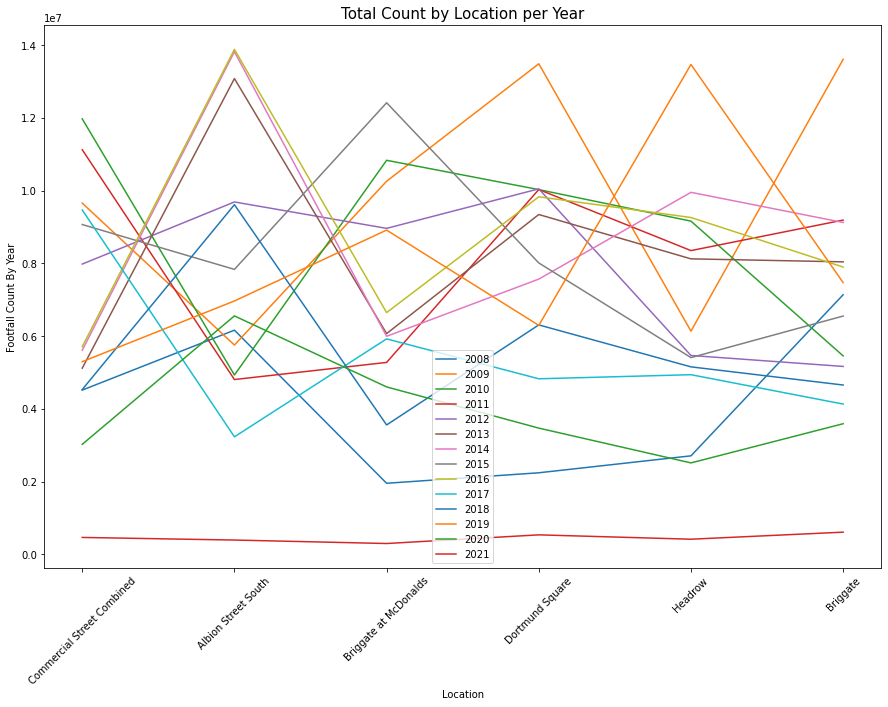

In [24]:
# Plot the all footfall counts per location per year 
fig, ax = plt.subplots(figsize=(15,10))
df_orig_samp1 = df_orig.drop_duplicates('LocationYear')
for name,group in df_orig_samp1.groupby(['Year']):
    group.plot.line(ax=ax, x="Location",y="TotCountByLocationByYear", label= str(name))
    ax.set_ylabel('Footfall Count By Year')
    ax.set_xlabel('Location')
    plt.title('Total Count by Location per Year', fontsize=15)
    plt.legend(loc='best')
    ax.tick_params(axis='x', rotation=45)

plt.show()

In [25]:
# Display all the total counts in each year split by day of the week
df_orig_samp2 = df_orig.drop_duplicates('YearWeekDay') # to remove entries having same 
df_orig_samp2 = df_orig_samp2[['WeekDayName', 'Year', 'TotCountByWeekDayByYear']]
df_orig_samp2 = df_orig_samp2.pivot(index='WeekDayName', columns='Year')
df_orig_samp2.columns = df_orig_samp2.columns.droplevel(0) # remove column name 'TotCountByWeekDayByYear' from display

df_orig_samp2.info()
df_orig_samp2.head(3)

<class 'pandas.core.frame.DataFrame'>
Index: 7 entries, Friday to Wednesday
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   2008    7 non-null      int64
 1   2009    7 non-null      int64
 2   2010    7 non-null      int64
 3   2011    7 non-null      int64
 4   2012    7 non-null      int64
 5   2013    7 non-null      int64
 6   2014    7 non-null      int64
 7   2015    7 non-null      int64
 8   2016    7 non-null      int64
 9   2017    7 non-null      int64
 10  2018    7 non-null      int64
 11  2019    7 non-null      int64
 12  2020    7 non-null      int64
 13  2021    7 non-null      int64
dtypes: int64(14)
memory usage: 840.0+ bytes


Year,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
WeekDayName,,,,,,,,,,,,,,
Friday,4263131,10246522,10407757,9319062,9567232,9699458,9756813,9122321,9958624,6580039,7016507,7567708,3500223,462294
Monday,4059069,9275339,9389841,8699899,8729673,8219921,8842836,7809620,9029180,5794394,6083822,6602823,3289836,476056
Saturday,5463795,13570125,12324072,11126224,10893508,11115397,11359552,11092320,11386178,6885811,6609945,7917648,3863741,584742


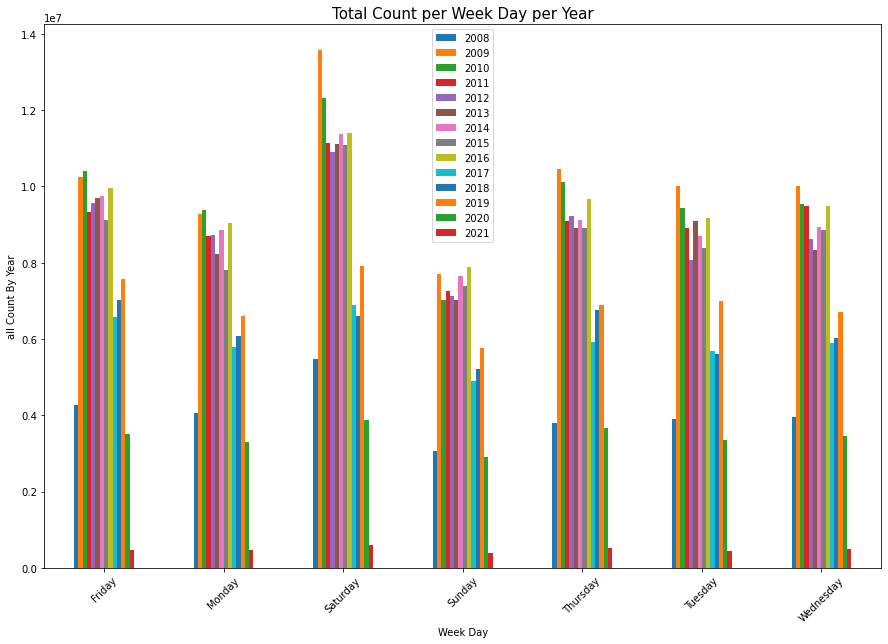

In [26]:
#plt.rcParams["figure.figsize"] = (15,10)
#fig = plt.figure()
#ax = fig.add_subplot()
# Plot the footfall counts of each year split by day of the week
fig, ax = plt.subplots(figsize=(15,10))
df_orig_samp2.plot(ax=ax, kind='bar')
ax.set_ylabel('all Count By Year')
ax.set_xlabel('Week Day')
plt.title('Total Count per Week Day per Year', fontsize=15)
plt.legend(loc='best')
ax.tick_params(axis='x', rotation=45)

plt.show()

In [27]:
# Display the total footfall counts by month 
df_orig_samp4 = df_orig.drop_duplicates('Month')
df_orig_samp4.groupby(['Month']).count().iloc[0,0:2]
df_orig_samp4 = df_orig_samp4[['Month', 'TotCountByMonth']]

df_orig_samp4.info()
df_orig_samp4.head(12)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 2008-01-09 to 2008-12-09
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Month            12 non-null     int64
 1   TotCountByMonth  12 non-null     int64
dtypes: int64(2)
memory usage: 288.0 bytes


,Month,TotCountByMonth
DateTime,,
2008-01-09,1,53681692
2008-02-09,2,53808696
2008-03-09,3,56624878
2008-04-09,4,57467219
2008-05-09,5,58895659
2008-06-09,6,56717282
2008-07-09,7,60216433
2008-08-09,8,60568005
2008-09-09,9,59419365


## TSA

R=-0.04137200394293204


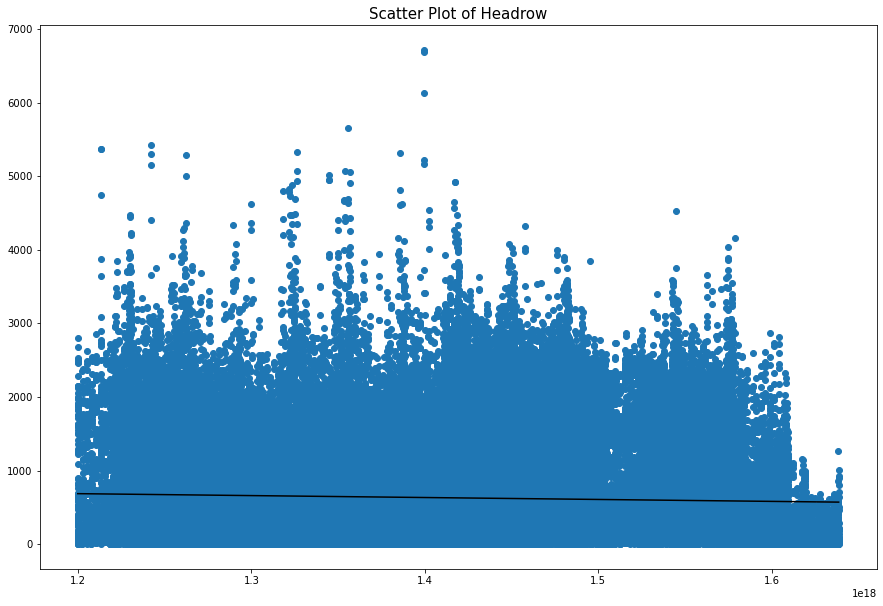

In [28]:
# Dependency 2
# nf
x = ts.index.values.tolist()
y = ts.Count.tolist()

slope, intercept, r, p, std_err = stats.linregress(x, y)
print('R=' + str(r))

def myfunc(x):
    return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel, color='black')
plt.title('Scatter Plot of ' + loc_name, fontsize=15)
plt.show()

In [29]:
ts.head()

,Count
DateTime,
2008-01-09 00:00:00,8
2008-01-09 01:00:00,9
2008-01-09 02:00:00,3
2008-01-09 03:00:00,6
2008-01-09 04:00:00,8


Location: Briggate


<Figure size 1080x720 with 0 Axes>

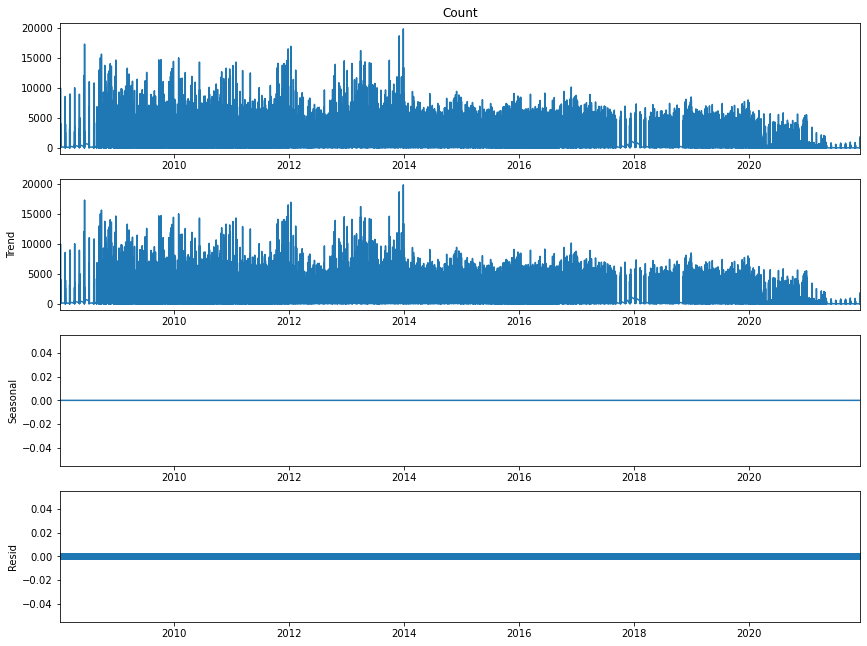

Location: Commercial Street Combined


<Figure size 1080x720 with 0 Axes>

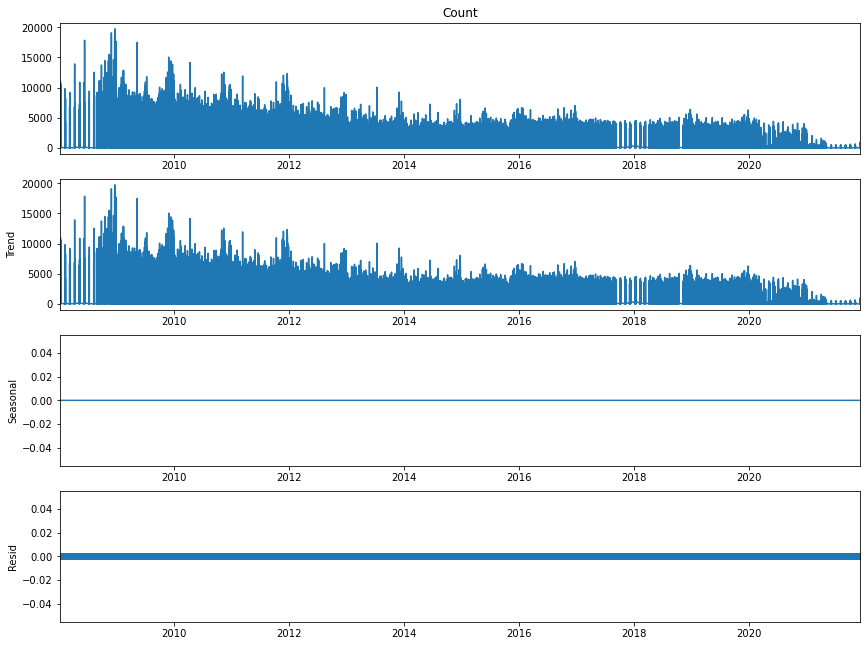

Location: Dortmund Square


<Figure size 1080x720 with 0 Axes>

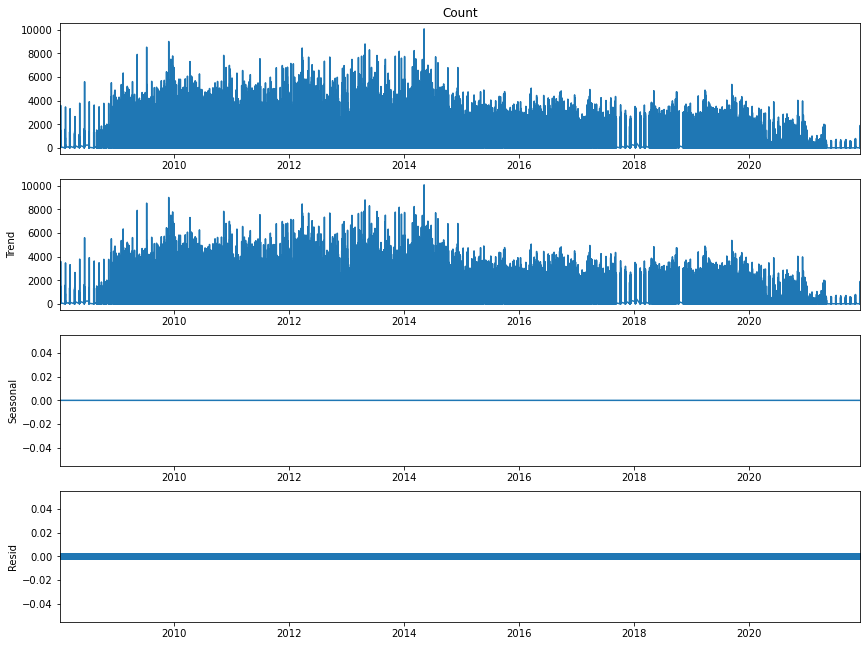

Location: Briggate at McDonalds


<Figure size 1080x720 with 0 Axes>

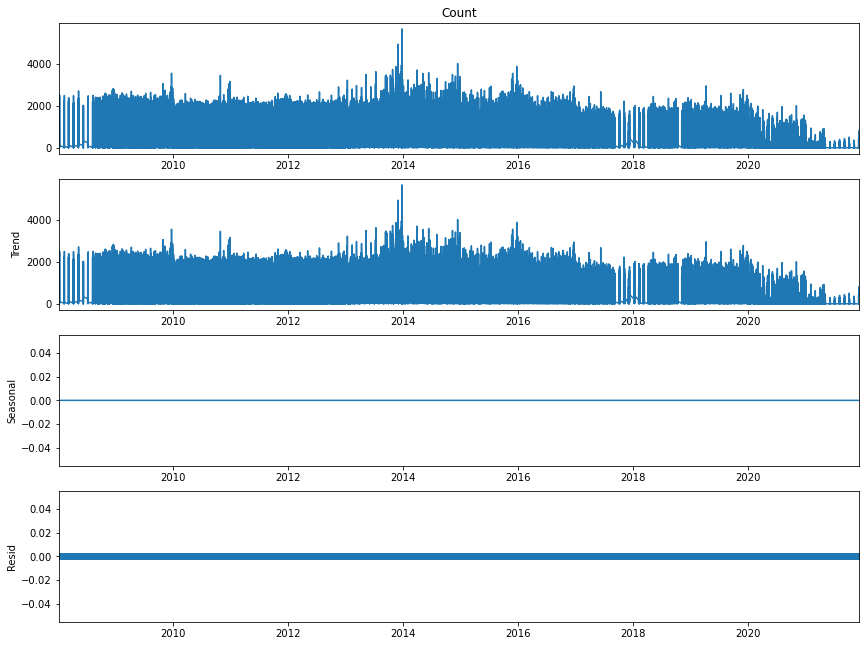

Location: Headrow


<Figure size 1080x720 with 0 Axes>

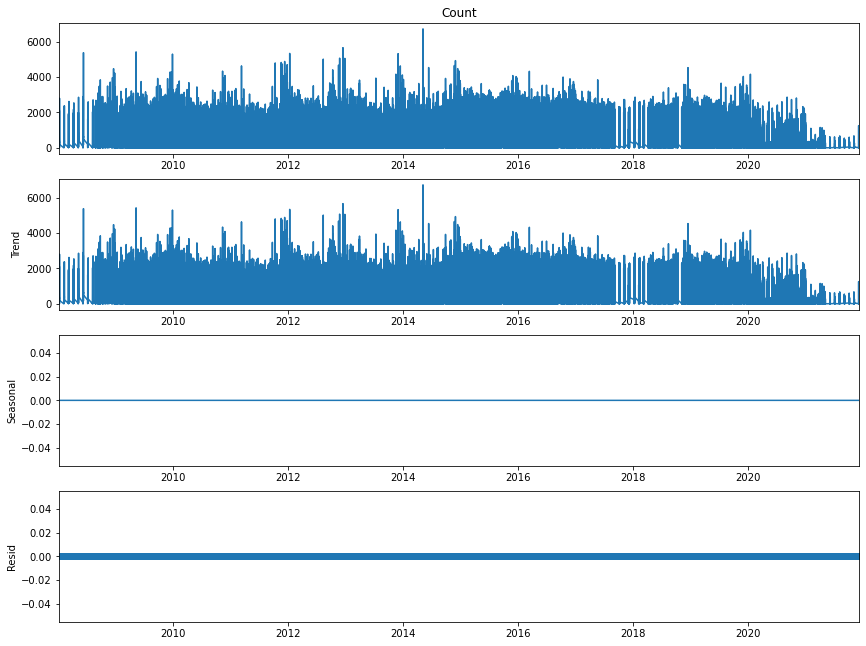

Location: Albion Street South


<Figure size 1080x720 with 0 Axes>

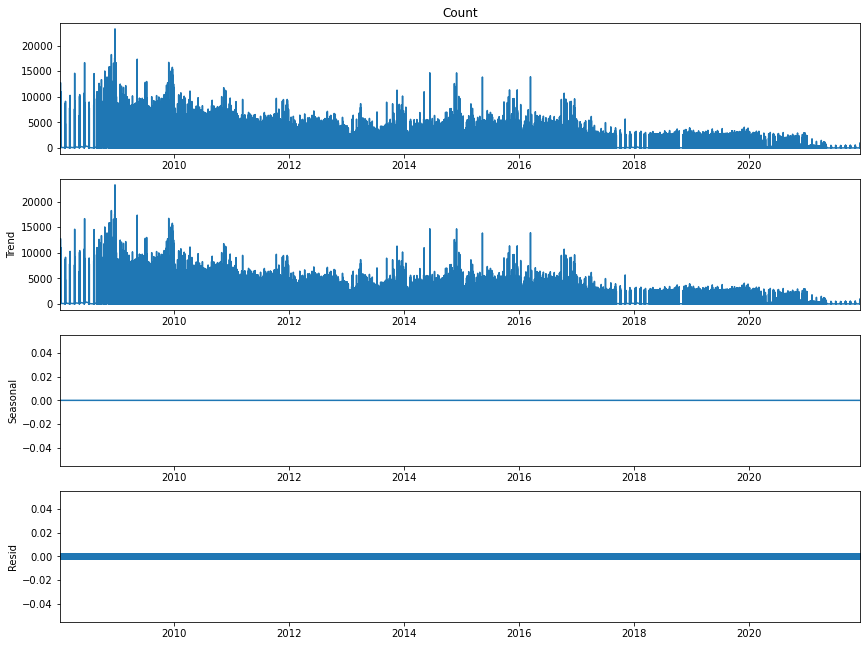

In [30]:
# Dependency 3
# display seasonal decompose result of all the locations
# nf
for key in dict_all.keys():
    result = seasonal_decompose(dict_all[key]['Count'], period=1)
    print('Location: ' + key)
    fig = plt.figure()  
    fig = result.plot()  
    fig.set_size_inches(12, 9)
    plt.show()

In [31]:
# Dependency 4
# Dependency 5
# nf
# Function to: plot the timeseries and stats with adjustable datetime x axis, rolling stats sections 
def plot_df(ts, name, interval, sec, choice):
    fig, ax = plt.subplots(figsize=(15,7))
    ax.plot(ts.index, ts.Count, label='Original')
    
    if 'rolmean' in choice:
        rolmean = ts['Count'].rolling(sec).mean()
        ax.plot(rolmean, label='Rolling Mean')
    if 'rolstd' in choice:
        rolstd = ts['Count'].rolling(sec).std()
        ax.plot(rolstd, label = 'Rolling Std')
    if 'expmean' in choice:
        expmean = ts['Count'].ewm(sec).mean()
        ax.plot(expmean, label = 'Exp Mean')
    
    plt.title(name, fontsize=15)
    plt.legend(loc='best')
    ax.set_ylabel('Footfall Count')
    ax.set_xlabel('DateTime')
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=interval))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    plt.gcf().autofmt_xdate()
    plt.show()
    

In [32]:
# nf
# Dependency 6
# Display the Dickey-Fuller test for stationarity of the timeseries
def test_stationarity(ts):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts['Count'])
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

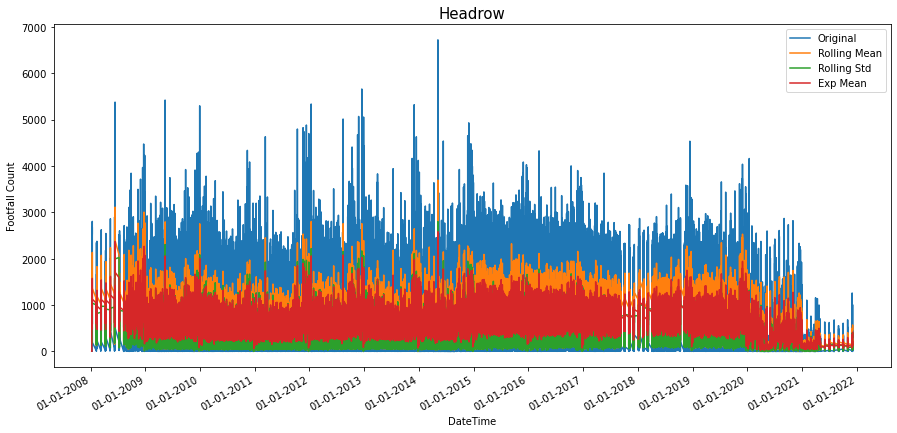

In [33]:
# nf
# Plot the timeseries of the selected location
plot_df(ts, loc_name, 12, 12, ['rolmean', 'rolstd', 'expmean'])

In [34]:
# Test the stationarity of the timeseries
test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                -1.767522e+01
p-value                        3.629325e-30
#Lags Used                     6.900000e+01
Number of Observations Used    1.048340e+05
Critical Value (1%)           -3.430412e+00
Critical Value (5%)           -2.861568e+00
Critical Value (10%)          -2.566785e+00
dtype: float64


In [35]:
# Dependency 7
# nf
# Adf test
#ndiffs(ts, test='adf')  #0

# KPSS test
#ndiffs(ts, test='kpss')  #1

# PP test:
#ndiffs(ts, test='pp') #0

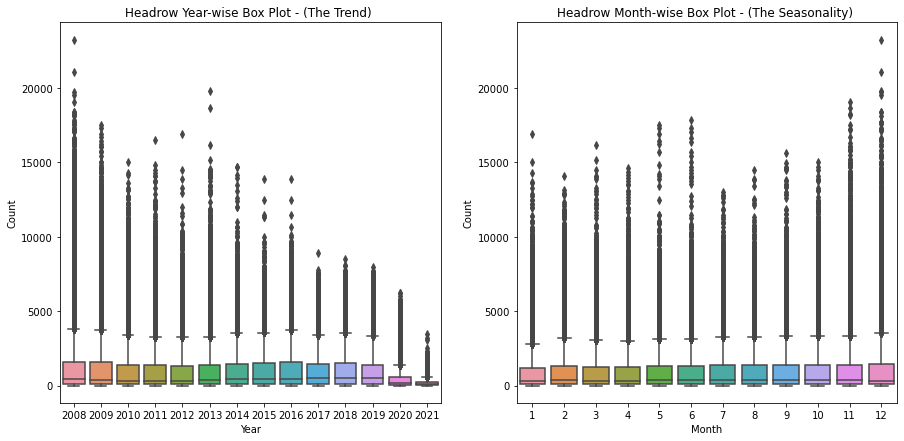

In [36]:
# Dependency 8
# nf
# Display the trend and seasonality via boxplot
fig, axes = plt.subplots(1, 2, figsize=(15,7))
sns.boxplot(x='Year', y='Count', data=df_all, ax=axes[0])
sns.boxplot(x='Month', y='Count', data=df_all, ax=axes[1])

axes[0].set_title(loc_name + ' Year-wise Box Plot - (The Trend) '); 
axes[1].set_title(loc_name + ' Month-wise Box Plot - (The Seasonality) ')
plt.show()

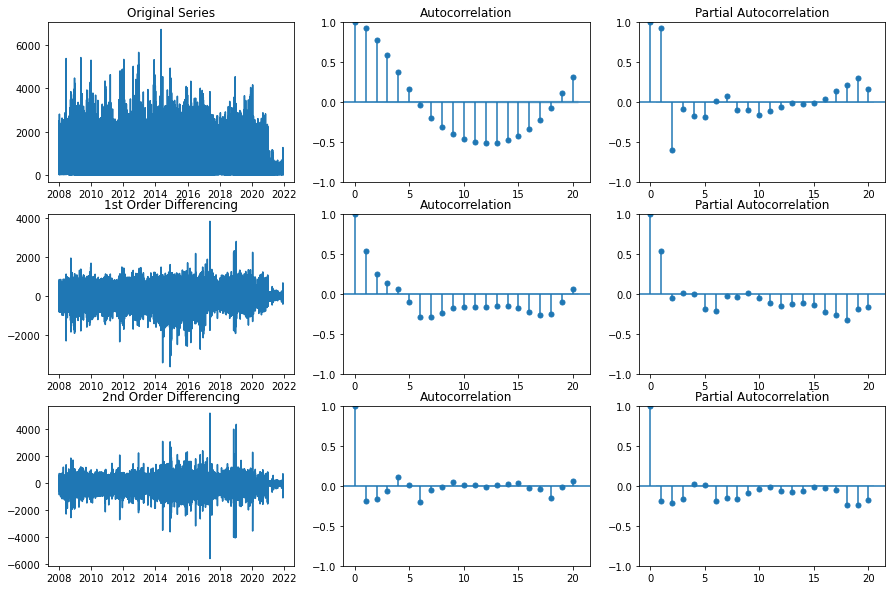

In [37]:
# Dependency 9
# nf

# Original timeseries

fig, axes = plt.subplots(3, 3)
axes[0, 0].plot(ts); axes[0, 0].set_title('Original Series')
plot_acf(ts, ax=axes[0, 1], lags=20)
plot_pacf(ts, ax=axes[0, 2], lags=20)

# 1st differencing
axes[1, 0].plot(ts.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(ts.diff().dropna(), ax=axes[1, 1], lags=20)
plot_pacf(ts.diff().dropna(), ax=axes[1, 2], lags=20)


# 2nd differencing
axes[2, 0].plot(ts.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(ts.diff().diff().dropna(), ax=axes[2, 1], lags=20)
plot_pacf(ts.diff().diff().dropna(), ax=axes[2, 2], lags=20)

plt.show()

## ARIMA model

### Basic

In [38]:
# Dependency 10
# nf
model = ARIMA(ts, order=(1,0,1))
model_fit = model.fit()

In [39]:
# nf
residuals = pd.DataFrame(model_fit.resid)

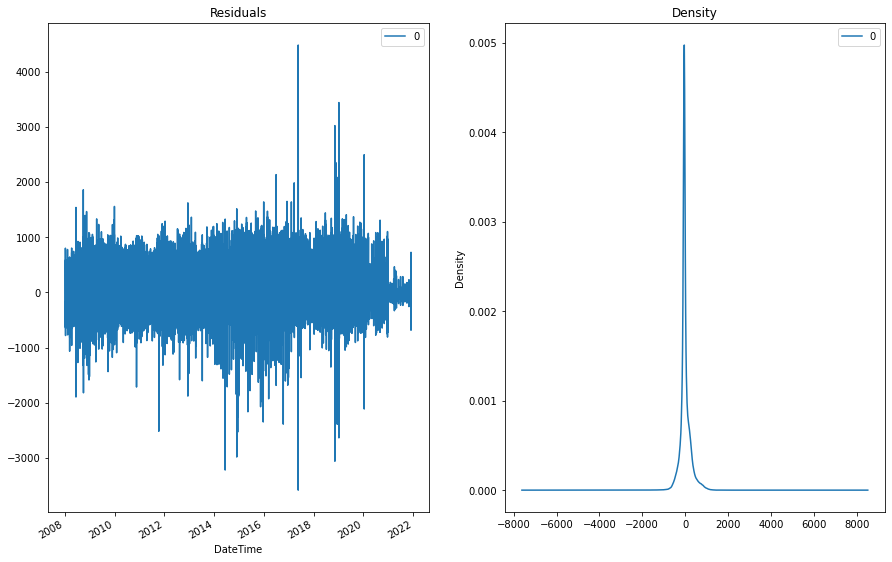

In [40]:
# Plot residual errors
# nf
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [41]:
forecast = model_fit.predict()

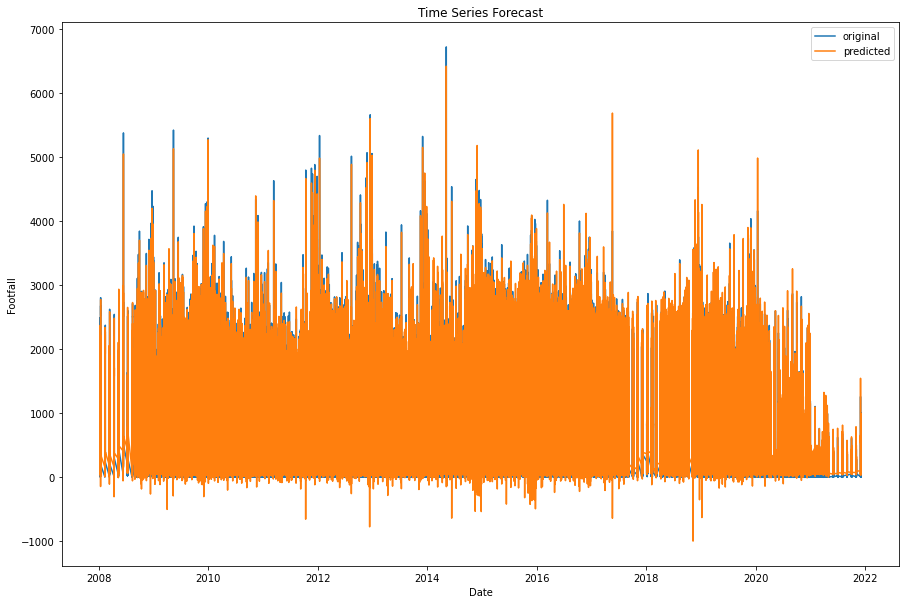

In [42]:
fig, ax = plt.subplots(1, 1)
plt.plot(ts, label = "original")
plt.plot(forecast, label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Footfall")
plt.legend()
plt.show()

### Consideration of na values

In [43]:
ts['Count'].isna()

DateTime
2008-01-09 00:00:00    False
2008-01-09 01:00:00    False
2008-01-09 02:00:00    False
2008-01-09 03:00:00    False
2008-01-09 04:00:00    False
                       ...  
2021-12-04 19:00:00    False
2021-12-04 20:00:00    False
2021-12-04 21:00:00    False
2021-12-04 22:00:00    False
2021-12-04 23:00:00    False
Name: Count, Length: 104904, dtype: bool

In [44]:
time_list=pd.date_range(start=ts.index[0], end=ts.index[-1], freq='H')
print(time_list)

DatetimeIndex(['2008-01-09 00:00:00', '2008-01-09 01:00:00',
               '2008-01-09 02:00:00', '2008-01-09 03:00:00',
               '2008-01-09 04:00:00', '2008-01-09 05:00:00',
               '2008-01-09 06:00:00', '2008-01-09 07:00:00',
               '2008-01-09 08:00:00', '2008-01-09 09:00:00',
               ...
               '2021-12-04 14:00:00', '2021-12-04 15:00:00',
               '2021-12-04 16:00:00', '2021-12-04 17:00:00',
               '2021-12-04 18:00:00', '2021-12-04 19:00:00',
               '2021-12-04 20:00:00', '2021-12-04 21:00:00',
               '2021-12-04 22:00:00', '2021-12-04 23:00:00'],
              dtype='datetime64[ns]', length=121896, freq='H')


In [45]:
# Dependency 11
ts_filled = ts.reindex(time_list, fill_value=np.nan)
ts_filled.info()
ts_filled.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121896 entries, 2008-01-09 00:00:00 to 2021-12-04 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Count   104904 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB


,Count
2008-01-09 00:00:00,8.0
2008-01-09 01:00:00,9.0
2008-01-09 02:00:00,3.0
2008-01-09 03:00:00,6.0
2008-01-09 04:00:00,8.0


In [46]:
ts_filled['Count'].isna()

2008-01-09 00:00:00    False
2008-01-09 01:00:00    False
2008-01-09 02:00:00    False
2008-01-09 03:00:00    False
2008-01-09 04:00:00    False
                       ...  
2021-12-04 19:00:00    False
2021-12-04 20:00:00    False
2021-12-04 21:00:00    False
2021-12-04 22:00:00    False
2021-12-04 23:00:00    False
Freq: H, Name: Count, Length: 121896, dtype: bool

In [47]:
model_nan = ARIMA(ts_filled, order=(1,0,1))
model_nan_fit = model_nan.fit()
print(model_nan_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Count   No. Observations:               121896
Model:                 ARIMA(1, 0, 1)   Log Likelihood             -722755.189
Date:                Thu, 22 Sep 2022   AIC                        1445518.378
Time:                        11:50:45   BIC                        1445557.222
Sample:                    01-09-2008   HQIC                       1445530.062
                         - 12-04-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        629.2688     13.984     45.000      0.000     601.861     656.676
ar.L1          0.8839      0.001    631.670      0.000       0.881       0.887
ma.L1          0.4936      0.001    339.795      0.0

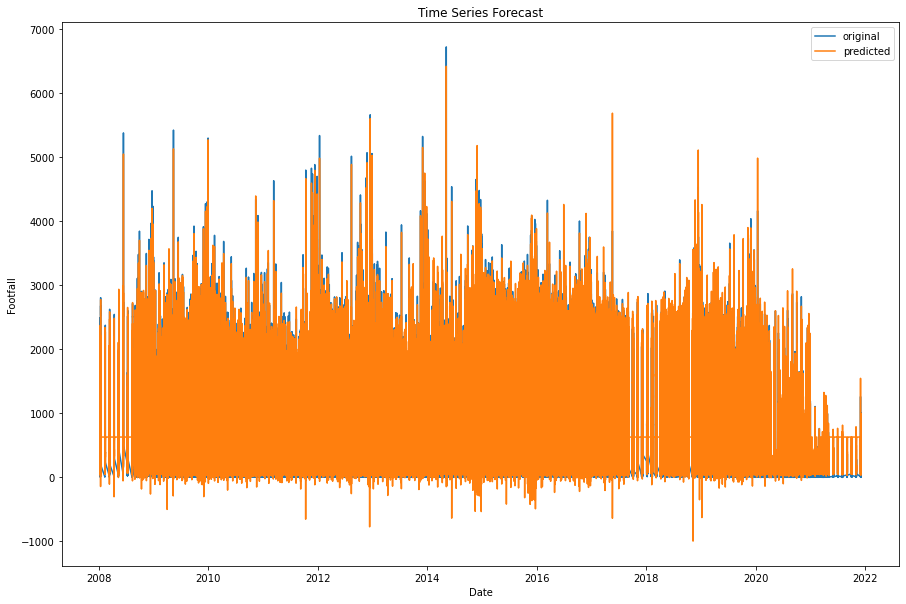

In [48]:
forecast_nan = model_nan_fit.predict()

fig, ax = plt.subplots(1, 1)
plt.plot(ts, label = "original")
plt.plot(forecast_nan, label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Footfall")
plt.legend()
plt.show()

### training attempt

In [ ]:
ts_monthly = ts.resample(rule='M')['Count'].sum()

ts_monthly.info()
ts_monthly.head()

In [60]:
train_0914 = ts_monthly.loc[pd.Timestamp('2009-01-01'):pd.Timestamp('2014-01-01')]
test_1415 = ts_monthly.loc[pd.Timestamp('2014-01-01'): pd.Timestamp('2015-01-01')]

train_0914.tail(5)

In [62]:
model_0914 = ARIMA(train_0914, order=(1, 0, 1))  
model_0914 = model_0914.fit()  

In [63]:
# Forecast
fc_1415 = model_0914.forecast(12)

print(fc_1415)

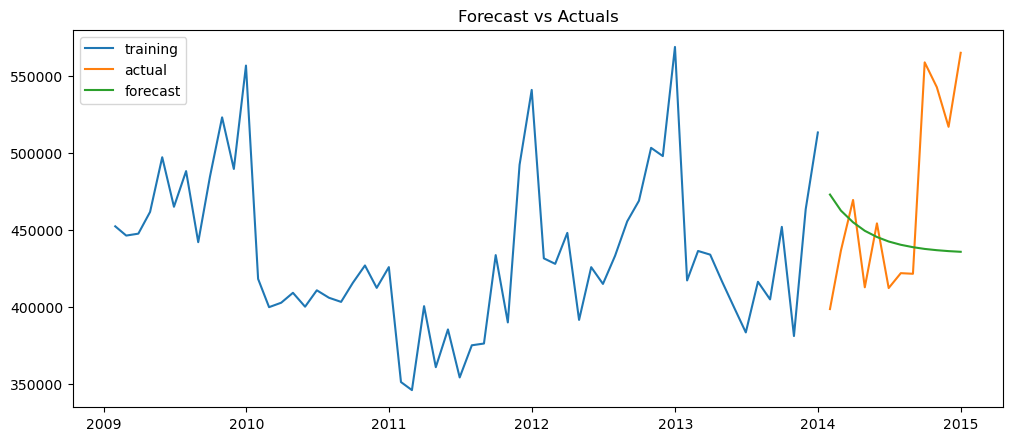

In [65]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_0914, label='training')
plt.plot(test_1415, label='actual')
plt.plot(fc_1415, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()

In [67]:
train_1015 = ts_monthly.loc[pd.Timestamp('2010-01-01'):pd.Timestamp('2015-01-01')]
test_1516 = ts_monthly.loc[pd.Timestamp('2015-01-01'): pd.Timestamp('2016-01-01')]

train_1015.tail(5)

DateTime
2014-08-31    421636
2014-09-30    558884
2014-10-31    542775
2014-11-30    517045
2014-12-31    565097
Freq: M, Name: Count, dtype: int64

In [68]:
model_1015 = ARIMA(train_1015, order=(1, 0, 1))  
model_1015 = model_1015.fit()  

In [69]:
# Forecast
fc_1516 = model_1015.forecast(12)

print(fc_1516)

2015-01-31    514881.291188
2015-02-28    497920.008046
2015-03-31    484444.114446
2015-04-30    473737.394514
2015-05-31    465230.808226
2015-06-30    458472.248113
2015-07-31    453102.510682
2015-08-31    448836.205494
2015-09-30    445446.587250
2015-10-31    442753.504750
2015-11-30    440613.826230
2015-12-31    438913.832200
Freq: M, Name: predicted_mean, dtype: float64


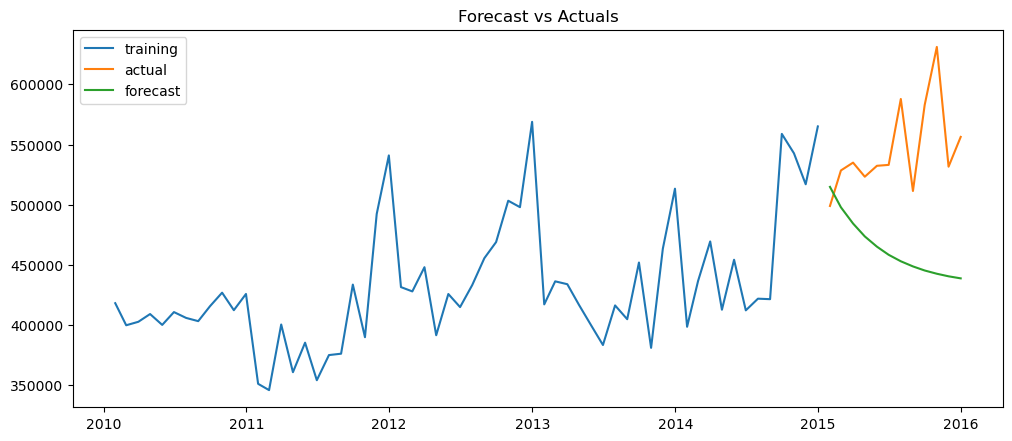

In [70]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_1015, label='training')
plt.plot(test_1516, label='actual')
plt.plot(fc_1516, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()

In [71]:
train_1116 = ts_monthly.loc[pd.Timestamp('2011-01-01'):pd.Timestamp('2016-01-01')]
test_1617 = ts_monthly.loc[pd.Timestamp('2016-01-01'): pd.Timestamp('2017-01-01')]

train_1116.tail(5)

DateTime
2015-08-31    511482
2015-09-30    582937
2015-10-31    631104
2015-11-30    531665
2015-12-31    556385
Freq: M, Name: Count, dtype: int64

In [72]:
model_1116 = ARIMA(train_1116, order=(1, 0, 1))  
model_1116 = model_1116.fit()  

In [73]:
# Forecast
fc_1617 = model_1116.forecast(12)

print(fc_1617)

2016-01-31    547475.890827
2016-02-29    541930.853995
2016-03-31    536734.729129
2016-04-30    531865.561540
2016-05-31    527302.777999
2016-06-30    523027.099815
2016-07-31    519020.461373
2016-08-31    515265.933808
2016-09-30    511747.653473
2016-10-31    508450.754915
2016-11-30    505361.308064
2016-12-31    502466.259376
Freq: M, Name: predicted_mean, dtype: float64


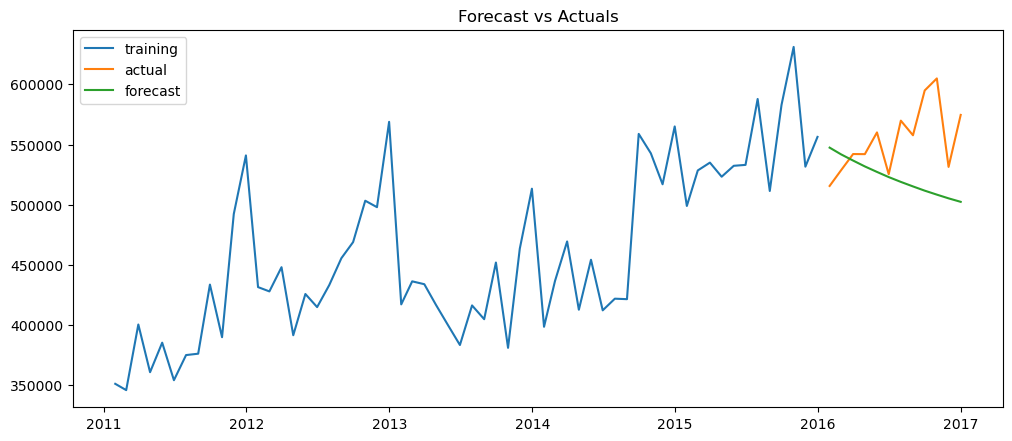

In [74]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_1116, label='training')
plt.plot(test_1617, label='actual')
plt.plot(fc_1617, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()

In [75]:
train_1217 = ts_monthly.loc[pd.Timestamp('2012-01-01'):pd.Timestamp('2017-01-01')]
test_1718 = ts_monthly.loc[pd.Timestamp('2017-01-01'): pd.Timestamp('2018-01-01')]

train_1217.tail(5)

DateTime
2016-08-31    557743
2016-09-30    594950
2016-10-31    604953
2016-11-30    531457
2016-12-31    574663
Freq: M, Name: Count, dtype: int64

In [76]:
model_1217 = ARIMA(train_1217, order=(1, 0, 1))  
model_1217 = model_1217.fit()  

In [77]:
# Forecast
fc_1718 = model_1217.forecast(12)

print(fc_1718)

2017-01-31    558561.892821
2017-02-28    554663.571247
2017-03-31    550986.965662
2017-04-30    547519.466028
2017-05-31    544249.179500
2017-06-30    541164.889636
2017-07-31    538256.017927
2017-08-31    535512.587511
2017-09-30    532925.188961
2017-10-31    530484.948005
2017-11-30    528183.495095
2017-12-31    526012.936699
Freq: M, Name: predicted_mean, dtype: float64


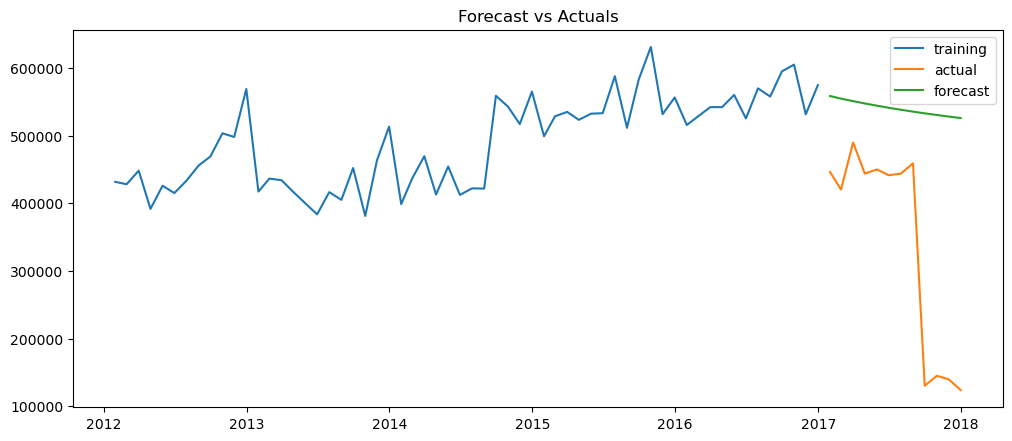

In [78]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_1217, label='training')
plt.plot(test_1718, label='actual')
plt.plot(fc_1718, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()

In [79]:
train_1318 = ts_monthly.loc[pd.Timestamp('2013-01-01'):pd.Timestamp('2018-01-01')]
test_1819 = ts_monthly.loc[pd.Timestamp('2018-01-01'): pd.Timestamp('2019-01-01')]

train_1318.tail(5)

DateTime
2017-08-31    459068
2017-09-30    130172
2017-10-31    144824
2017-11-30    139829
2017-12-31    123707
Freq: M, Name: Count, dtype: int64

In [80]:
model_1318 = ARIMA(train_1318, order=(1, 0, 1))  
model_1318 = model_1318.fit()  

In [81]:
# Forecast
fc_1819 = model_1318.forecast(12)

print(fc_1819)

2018-01-31    151980.351231
2018-02-28    168275.187296
2018-03-31    183729.166158
2018-04-30    198385.678301
2018-05-31    212285.875145
2018-06-30    225468.784586
2018-07-31    237971.420575
2018-08-31    249828.887046
2018-09-30    261074.476474
2018-10-31    271739.763355
2018-11-30    281854.692855
2018-12-31    291447.664889
Freq: M, Name: predicted_mean, dtype: float64


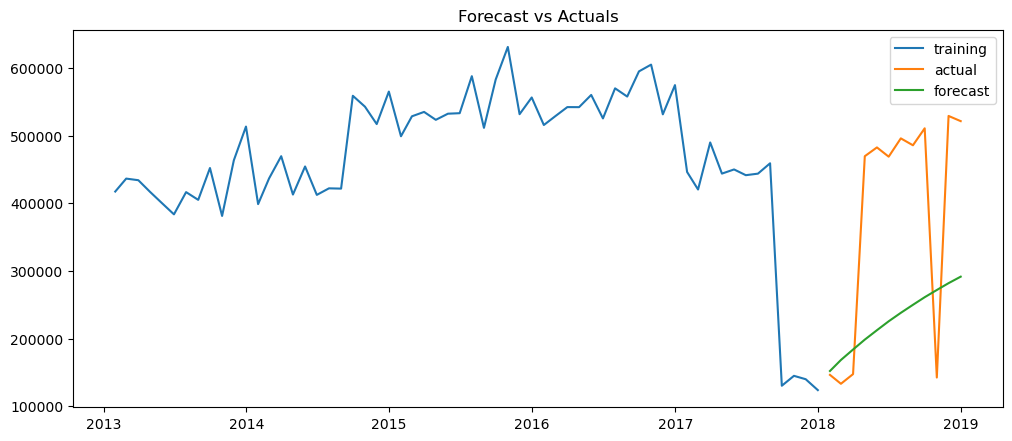

In [82]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_1318, label='training')
plt.plot(test_1819, label='actual')
plt.plot(fc_1819, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()

In [83]:
train_1419 = ts_monthly.loc[pd.Timestamp('2014-01-01'):pd.Timestamp('2019-01-01')]
test_1920 = ts_monthly.loc[pd.Timestamp('2019-01-01'): pd.Timestamp('2020-01-01')]

train_1419.tail(5)

DateTime
2018-08-31    485708
2018-09-30    510798
2018-10-31    142321
2018-11-30    529081
2018-12-31    521395
Freq: M, Name: Count, dtype: int64

In [84]:
model_1419 = ARIMA(train_1419, order=(1, 0, 1))  
model_1419 = model_1419.fit()  

In [85]:
# Forecast
fc_1920 = model_1419.forecast(12)

print(fc_1920)

2019-01-31    492601.029756
2019-02-28    487091.328158
2019-03-31    482458.379620
2019-04-30    478562.667343
2019-05-31    475286.875690
2019-06-30    472532.357342
2019-07-31    470216.162620
2019-08-31    468268.541545
2019-09-30    466630.843377
2019-10-31    465253.750408
2019-11-30    464095.792804
2019-12-31    463122.099784
Freq: M, Name: predicted_mean, dtype: float64


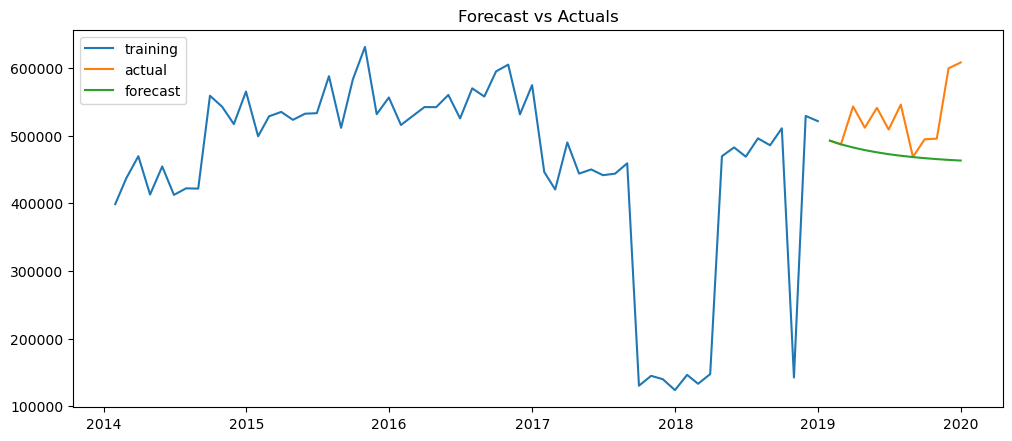

In [86]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_1419, label='training')
plt.plot(test_1920, label='actual')
plt.plot(fc_1920, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()